In [1]:
#import  libraries,packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from data_reduction_columns import * 
from predict import *
from datetime import datetime
%load_ext autoreload
%autoreload 2

In [2]:
from predict import *

In [3]:
#import scikit-learn functions
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

Fannie Mae publishes quarterly data on loan acquisitions and performance in single file from the year of 2000. For the analysis purpose data from 2016 is considered. The entire dataset is very huge  Therefore, the important data is compiled into a single file with reduce_data.py before beginning this analysis. This routine serves to clean and trim the data, calculate a few values that will be useful later like the loan age, and identify loans that were foreclosed on. Acquistion and Performance files are so large they cannot be completely read into memory so "chunking" is used in the read_table function.  Additionally, data is sorted based on reporting period and most recent reporting period data for a given loan is considered as that gives the information wherther loan is foreclosured or not.


Lets start by analying the housing market during 2017 and 2016. What are the houses selling for, what's the range  and how levered are borrowers?

In [73]:
data = pd.read_table(DATA_DIR_OUTPUT+DATA_FILE,sep=",")

In [5]:
data.shape



(4336086, 37)

In [6]:
data['originalLoanAmt'].head(4)

0    238000.0
1     65000.0
2    153000.0
3    150000.0
Name: originalLoanAmt, dtype: float64

In [7]:
data.columns

Index(['loanId', 'reporting_period', 'channel', 'seller', 'interest_rate',
       'current_interest_rate', 'originalLoanAmt', 'loan_term',
       'origination_date', 'balance', 'loan_age', 'maturity_date', 'ltv',
       'cltv', 'borrowers_count', 'dti', 'borrower_credit_score',
       'co-borrower_credit_score', 'first_time_homebuyer', 'loan_purpose',
       'property_type', 'units_num', 'property_state', 'zip', 'recovery_costs',
       'borrower_credit_score_current', 'co-borrower_credit_score_current',
       'insurance_type', 'foreclosure_date', 'relocation_indicator',
       'insurance_percentage', 'high_balance_loan_ind', 'acquisition_date',
       'origination_date_month', 'origination_date_year', 'property_state_n',
       'foreclosured'],
      dtype='object')

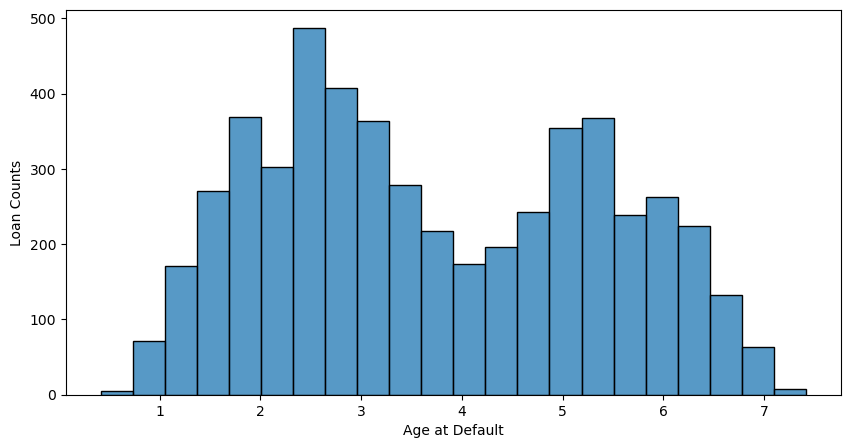

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

# Clean data and plot distribution of lifetimes for defaults
age_data = data[['origination_date','foreclosure_date']].dropna(axis=0, how='any')

age_data['origination_date'] = pd.to_datetime(age_data['origination_date'].apply(lambda x: f'01{x}'), format='%d%m%Y')

# Convert 'foreclosure_date' to datetime
age_data['foreclosure_date'] = pd.to_datetime(age_data['foreclosure_date'].apply(lambda x: f'01{int(x)}'), format='%d%m%Y')

age_data['loan_age_years'] = (age_data['foreclosure_date'] - age_data['origination_date']).dt.days / 365.25

#sns.displot(age_data['loan_age_years'])
sns.histplot(age_data['loan_age_years'])
ax.set_ylabel('Loan Counts')
ax.set_xlabel('Age at Default');

In [9]:
age_data.shape

(5209, 3)

In [10]:
age_data['foreclosure_date']-age_data['origination_date'].head(5)

1678      1036 days
2071       577 days
2596      1887 days
3376      1034 days
4340       638 days
             ...   
4333165         NaT
4333972         NaT
4335192         NaT
4335803         NaT
4335863         NaT
Length: 5209, dtype: timedelta64[ns]

In [11]:
description = data[['originalLoanAmt','balance', 
                             'interest_rate', 
                             'dti', 
                             'loan_term',
                             'insurance_percentage'
                             ]].describe()
print(description[1:].round(2))


      originalLoanAmt     balance  interest_rate    dti  loan_term  \
mean        232440.75    51274.56           3.93  33.79     318.49   
std         119673.99    92009.71           0.54   9.10      74.83   
min           5000.00        0.00           1.75   0.00      36.00   
25%         140000.00        0.00           3.62  27.00     360.00   
50%         211000.00        0.00           3.99  35.00     360.00   
75%         307000.00    83364.28           4.25  41.00     360.00   
max        1223000.00  1227922.05           6.12  63.00     360.00   

      insurance_percentage  
mean                 24.83  
std                   7.00  
min                   1.00  
25%                  25.00  
50%                  25.00  
75%                  30.00  
max                  42.00  


In [12]:
data = data.drop(columns=["recovery_costs","foreclosure_date","borrower_credit_score_current","co-borrower_credit_score_current","insurance_type","co-borrower_credit_score","maturity_date"])
data.isnull().sum()

loanId                          0
reporting_period                0
channel                         0
seller                         70
interest_rate                   0
current_interest_rate     2921632
originalLoanAmt                 0
loan_term                       0
origination_date                0
balance                         0
loan_age                        0
ltv                             0
cltv                            0
borrowers_count                 0
dti                           353
borrower_credit_score        2409
first_time_homebuyer            0
loan_purpose                    0
property_type                   0
units_num                       0
property_state                  0
zip                             5
relocation_indicator            0
insurance_percentage      3109074
high_balance_loan_ind           0
acquisition_date                0
origination_date_month          0
origination_date_year           0
property_state_n                0
foreclosured  

as per 2017 and 2016 data, loan balance range is huge.Also original loan amt varies from 200k to 1 million.  Interest Rate goes from 2% to 6 %. Most of the loans are 30 years loan

Lets look at the foreclosure data, we are counting number of foreclosed houses and calculate the rate at which they occur

In [65]:
(good,default) = pd.value_counts(data['foreclosured'])
print('Total Defaults =',default)
print('Total Good loans =',good)
print('Default Rate {:.1%}'.format(100 *default/(good+default))) 

grouped_data = data.groupby('origination_date_year')['foreclosured'].value_counts().unstack()
print(grouped_data)
for year,row in grouped_data.iterrows():
    print(f"{year} had {row[1]} defaults")

Total Defaults = 5209
Total Good loans = 4330877
Default Rate 12.0%
foreclosured                   0       1
origination_date_year                   
2013                         4.0     NaN
2014                       137.0     NaN
2015                    170561.0   272.0
2016                   2351021.0  2629.0
2017                   1809154.0  2308.0
2013 had nan defaults
2014 had nan defaults
2015 had 272.0 defaults
2016 had 2629.0 defaults
2017 had 2308.0 defaults


We have totaly 566  foreclosures wto work with, which is will helps us identify any characterstics of foreclosure. But they account for onlya  small percentage(11%).This means it is rare that a mortage defaults we need to keep account for this. We can use analytics to characterize groups that may have tendency to run into liquidity issues or buy at the wrong times. 


Lets analyse data to draw groups that have tendency for foreclosure. Debt to income ratios, primary  borrower's credit scores, loan to value ration are import features to consider, lets begin from here by drawing box and whisker plots for the same. These values helps agency to asses the credit worthiness of the borrower and relative riks of the loans.

In [14]:
for column in ["channel","seller","first_time_homebuyer","loan_purpose","property_type","property_state","high_balance_loan_ind",
        "relocation_indicator","loan_purpose"]:
        data[column] = data[column].astype('category').cat.codes

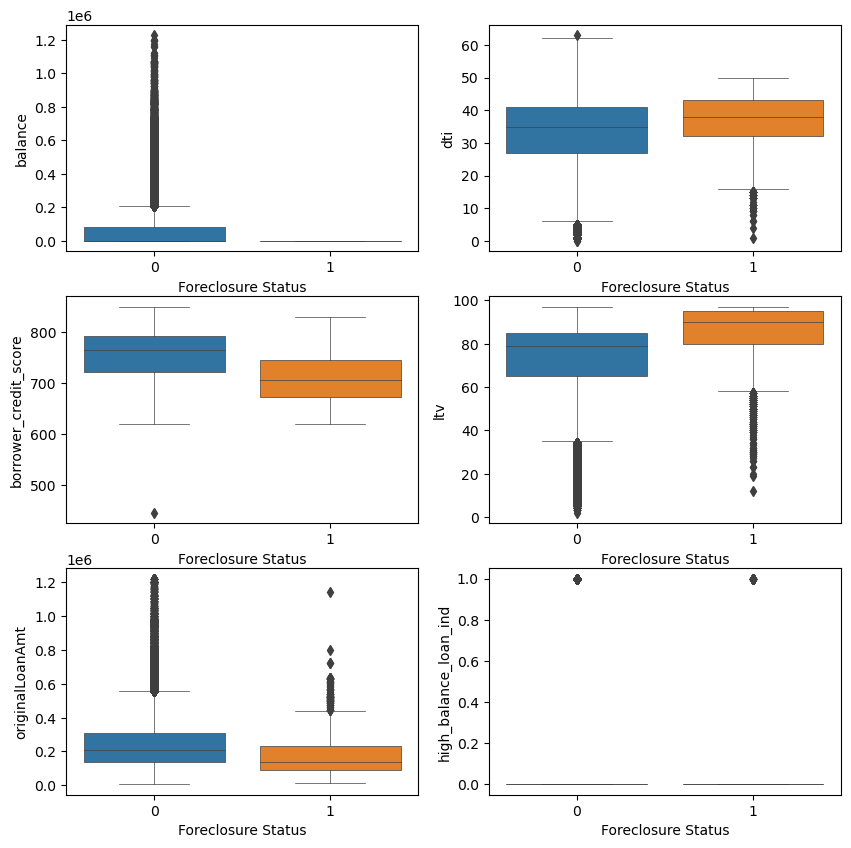

In [15]:
#columns to plot
columns = ['balance', 'dti','borrower_credit_score','ltv','originalLoanAmt','high_balance_loan_ind']

#make plot
fig, axes = plt.subplots(3, 2, figsize=(10,10))
for i, column in zip(range(1,7), columns):
    plt.subplot(3,2,i)
    sns.boxplot(x="foreclosured", y=column, data=data, linewidth=0.5)
    plt.xlabel('Foreclosure Status')



Box plots shows small variance among default and good loans

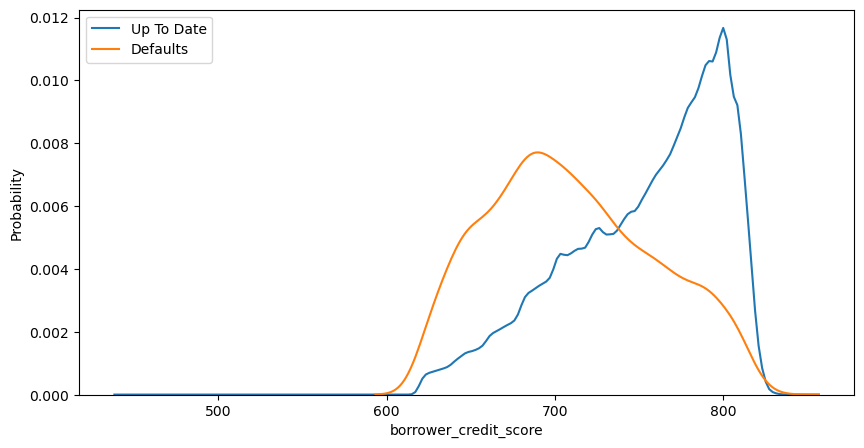

In [16]:
# Set-up plot and data
fig, ax = plt.subplots(1, 1, figsize=(10,5))
dist_data = data[['borrower_credit_score', 'foreclosured']].dropna(axis=0, how='any')

# Filter and plot non-foreclosed mortgages
good_credit_scores = dist_data[dist_data['foreclosured']==0]
sns.kdeplot(good_credit_scores['borrower_credit_score'], label = 'Up To Date')

# Filter and plot foreclosed mortgages
default_credit_scores = dist_data[dist_data['foreclosured']==1]
sns.kdeplot(default_credit_scores['borrower_credit_score'], label='Defaults')
ax.set_ylabel('Probability')
ax.legend();

probability density graph is showing that graph curve is different for defaults and good loans. Good loans are skewed towards right with high credit score where as default one was skewed towards left with peak of curve is around less than 700 credit score. But the interest rate among good and default is not varing much.

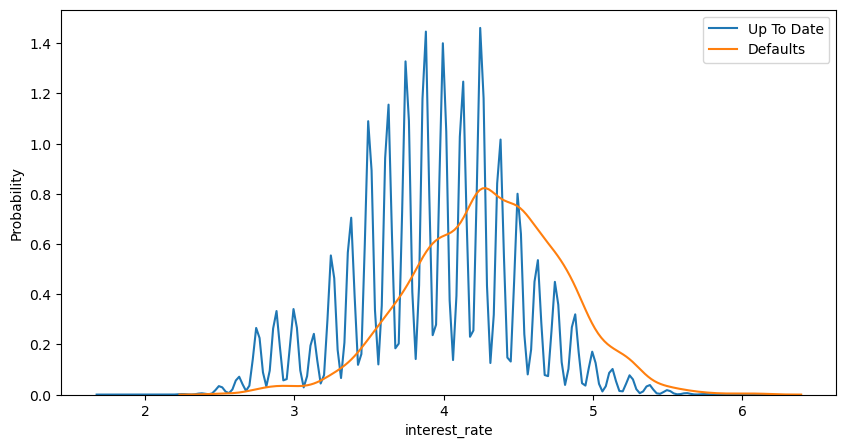

In [17]:
fig,ax = plt.subplots(1, 1, figsize=(10,5))
dist_data_1 = data[['interest_rate','foreclosured']].dropna(axis =0, how ='any')

# Filter and plot non-foreclosed mortgages
good_credit_scores = dist_data_1[dist_data_1['foreclosured']==0]
sns.kdeplot(good_credit_scores['interest_rate'], label = 'Up To Date')

# Filter and plot foreclosed mortgages
default_credit_scores = dist_data_1[dist_data_1['foreclosured']==1]
sns.kdeplot(default_credit_scores['interest_rate'], label='Defaults')
ax.set_ylabel('Probability')
ax.legend();

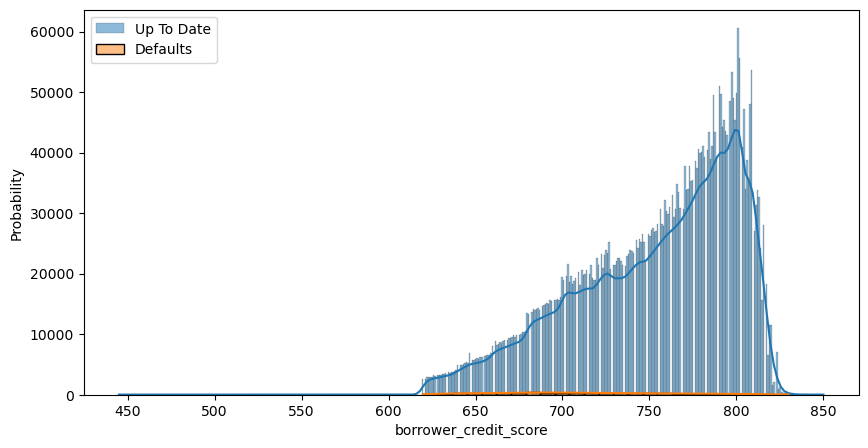

In [18]:
# Set-up plot and data
fig, ax = plt.subplots(1, 1, figsize=(10,5))
dist_data_2 = data[['borrower_credit_score', 'foreclosured']].dropna(axis=0, how='any')

# Filter and plot non-foreclosed mortgages
good_credit_scores = dist_data_2[dist_data_2['foreclosured']==0]
sns.histplot(good_credit_scores['borrower_credit_score'], label = 'Up To Date', kde= True)

# Filter and plot foreclosed mortgages
default_credit_scores = dist_data_2[dist_data_2['foreclosured']==1]
sns.histplot(default_credit_scores['borrower_credit_score'], label='Defaults', kde= True)
ax.set_ylabel('Probability')
ax.legend();

negative value of pearson shows perfecy negative relationship that ie. borrower with good credit score gets lower interest rate. At the same time borrower with low credit score do gets loans but with higher interest rate.

In [19]:
print(data['interest_rate'].corr(data['borrower_credit_score'], method='pearson'))

-0.31773177295969035


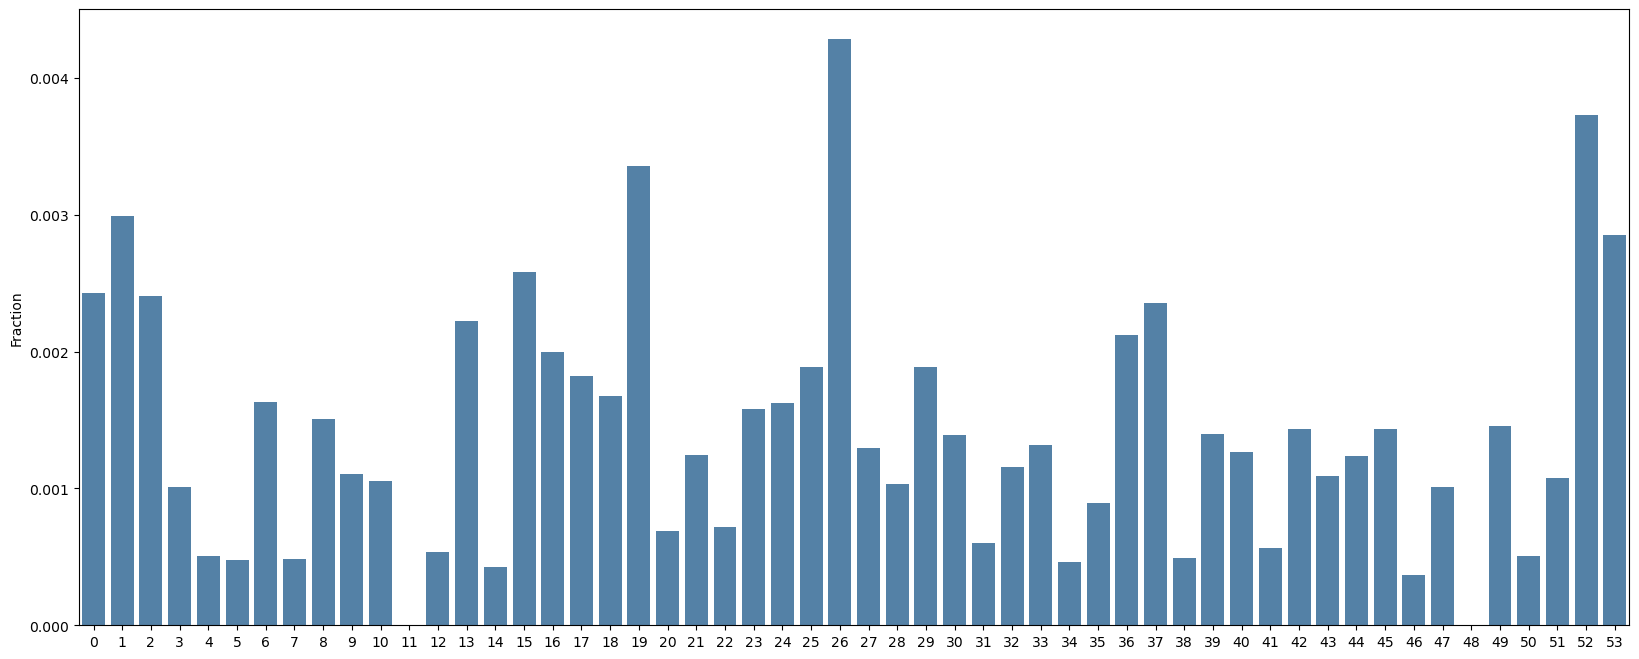

In [20]:
# Count number of mortgages per state
states_mort = pd.value_counts(data['property_state'])

# Count number of foreclosures and get ratio
states_defaults = data[data['foreclosured']==1]
states_foreclose_count = pd.value_counts(states_defaults['property_state']).sort_index()
states_mort = pd.concat([states_mort, states_foreclose_count], axis=1).fillna(0)
states_mort =states_mort.sort_index()
states_mort.columns = ['totals','defaults']

# Plot foreclosure rates
fig, ax = plt.subplots(1, 1, figsize=(20,8))
sns.barplot(x=states_mort.index, y=states_mort['defaults']/states_mort['totals'], color='steelblue')
#sns.barplot(x=states_mort.index, y=states_mort['totals'], color='steelblue')
ax.set_ylabel('Fraction');



2016 abd 2017 data shows states having various foreclosure rates. Few states have very huge foreclosure rates where as few states have nil.since data combine two years of data 2016 and 217, we can also check whether each year foreclosure rate is different. 2016 and 2017 data files have loans which are originated from 2013 onwards. lets check the foreclosure of houses based on origination date.

In [21]:
grouped_data = data.groupby(['origination_date_year','foreclosured']).size().reset_index(name='count')
print(grouped_data)

   origination_date_year  foreclosured    count
0                   2013             0        4
1                   2014             0      137
2                   2015             0   170561
3                   2015             1      272
4                   2016             0  2351021
5                   2016             1     2629
6                   2017             0  1809154
7                   2017             1     2308


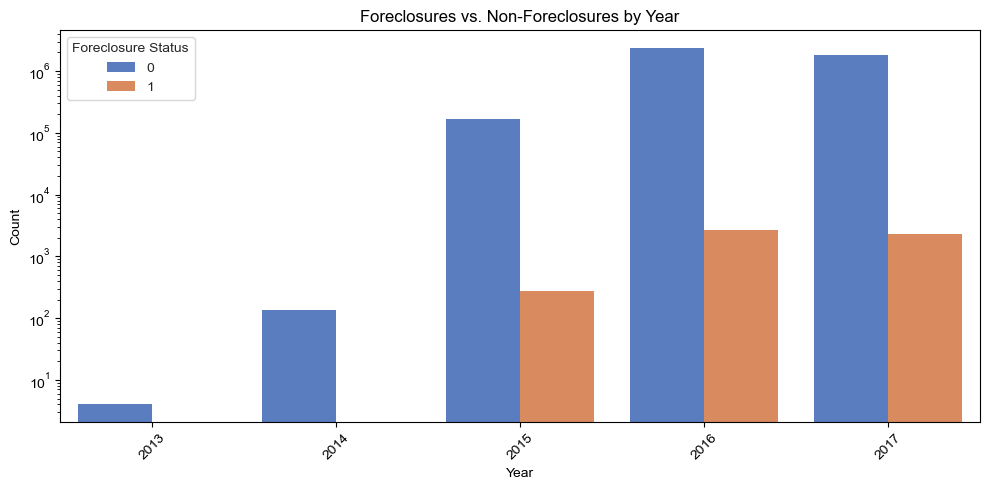

In [22]:
plt.figure(figsize=(10,5))
sns.barplot(data=grouped_data, x ='origination_date_year', y = 'count', hue='foreclosured',palette='muted',dodge=0.2)
# Create a bar plot with overlapped bars
sns.set_style("whitegrid")

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Foreclosures vs. Non-Foreclosures by Year')
plt.yscale('log')
# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.legend(title='Foreclosure Status', loc='upper left')
plt.tight_layout()
plt.show()


In [23]:
print('Interest Rate - Credit Score Correlation = ', data['interest_rate'].corr(data['borrower_credit_score'], method='pearson'))
print('Interest Rate - Debt Level = ', data['interest_rate'].corr(data['cltv'], method='pearson'))
print('Interest Rate - Loan Term = ', data['interest_rate'].corr(data['loan_term'], method='pearson'))

Interest Rate - Credit Score Correlation =  -0.31773177295969035
Interest Rate - Debt Level =  0.27782892918325325
Interest Rate - Loan Term =  0.591473485024441


To fit the logit function data will split into training and testing set. Data is highly imbalnced as foreclosured house count is way less compared to good houses. Due to this imbalance of data cross validation is used. Also to check the features that impact foreclosure feature selection function is used.Looks like credit score and loan balance do affect the foreclosured loans 

In [27]:
print(data['first_time_homebuyer'].unique())

[0 1]


In [25]:
feature_selection(data)

Selected feature indices: [2 5]
Selected feature indices: ['originalLoanAmt', 'borrower_credit_score']


In [26]:
print(data['channel'].value_counts())

2    2583036
1    1324175
0     428875
Name: channel, dtype: int64


In [28]:
make_logistic_predictions(data)

****filtered_data*****
LogicsticRegression: Cross-Validation Scores: [0.66052856 0.6602979  0.66013364]
Mean CV Score: 0.6603200342960457
LogicsticRegression: Standard Deviation of CV Scores: 0.00016198212822645262
LogicsticRegression : Test Set Accuracy: 0.9975074071053848
Confusion matrix
[[366973      0]
 [   917      0]]
************* LogicsticRegression Classification report ***************************


C:\Users\Pallavi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Pallavi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    366973
           1       0.00      0.00      0.00       917

    accuracy                           1.00    367890
   macro avg       0.50      0.50      0.50    367890
weighted avg       1.00      1.00      1.00    367890

***********************************************************************************
LogicsticRegression Accuracy score " 0.9975074071053848


C:\Users\Pallavi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1) Above results shows precison  for identifying the foreclousred loans is nil  where as number of forclosured loans correctly identified as positive out of all is 72%.
2) looking at confusion matrix only 1129 loans are identified correctly out of Total Defaults = 5209 
3) since number of default loans are very less compared to good one, we need to focus on F1 Score

In [29]:
make_LogicsticRegression_scaled(data)
   

************* LogicsticRegression Classification report for scaled data***************************
****filtered_data*****
LogicsticRegression: Cross-Validation Scores -- scaled data: [0.70362345 0.70904046 0.70315165]
Mean CV Score: 0.7052718520796638
LogicsticRegression: Standard Deviation of CV Scores - scaled data: 0.002671757588107359
Test Set Accuracy: 0.7051564326293186
Confusion matrix
[[258757 108216]
 [   254    663]]
              precision    recall  f1-score   support

           0       1.00      0.71      0.83    366973
           1       0.01      0.72      0.01       917

    accuracy                           0.71    367890
   macro avg       0.50      0.71      0.42    367890
weighted avg       1.00      0.71      0.82    367890

*************************************************************************************************
LogicsticRegression Accuracy score -- scaled data " 0.7051564326293186


In [28]:
optimalC = Cvalue_section(data)

****filtered_data*****


In [29]:
print(optimalC)

0.1


In [30]:
# calling the logistic regresiion method with optimal C value
make_logistic_predictions(data,optimalC)

****filtered_data*****
LogicsticRegression: Cross-Validation Scores: [0.66572189 0.65967931 0.99750468]
Mean CV Score: 0.774301963635008
LogicsticRegression: Standard Deviation of CV Scores: 0.15784743409395455
LogicsticRegression : Test Set Accuracy: 0.6603549974177064
Confusion matrix
[[242357 124616]
 [   336    581]]
************* LogicsticRegression Classification report ***************************
              precision    recall  f1-score   support

           0       1.00      0.66      0.80    366973
           1       0.00      0.63      0.01       917

    accuracy                           0.66    367890
   macro avg       0.50      0.65      0.40    367890
weighted avg       1.00      0.66      0.79    367890

***********************************************************************************
LogicsticRegression Accuracy score " 0.6603549974177064


In [31]:
print(data['first_time_homebuyer'].unique())


#filtered_data["first_time_homebuyer"]= filtered_data["first_time_homebuyer"].map({'Y':1 ,'N':0})
#bestFeatures, bestParams = best_random_forest_parameters(data)

[0 1]


In [32]:
bestFeatures, bestParams = best_random_forest_parameters(data)

   

****filtered_data*****
Best parameters for random forest classification are  {'n_estimators': 30, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None, 'criterion': 'gini'}
**********************Features with importance *******************************
{'originalLoanAmt': 0.16102288121837935, 'interest_rate': 0.08661349163973363, 'borrowers_count': 0.045113756438833016, 'dti': 0.09599071502115944, 'loan_term': 0.006577517095304195, 'cltv': 0.04308895291895008, 'ltv': 0.035803163584265, 'loan_age': 0.1645429360891354, 'borrower_credit_score': 0.1986631638199225, 'high_balance_loan_ind': 0.0015682772400273822, 'first_time_homebuyer': 0.014175278333886052, 'insurance_percentage': 0.024025166975759096, 'zip': 0.12281469962464489}


In [11]:
print(data["high_balance_loan_ind"].unique())
print(data["relocation_indicator"] .unique())


[0 1]
[0 1]


gini


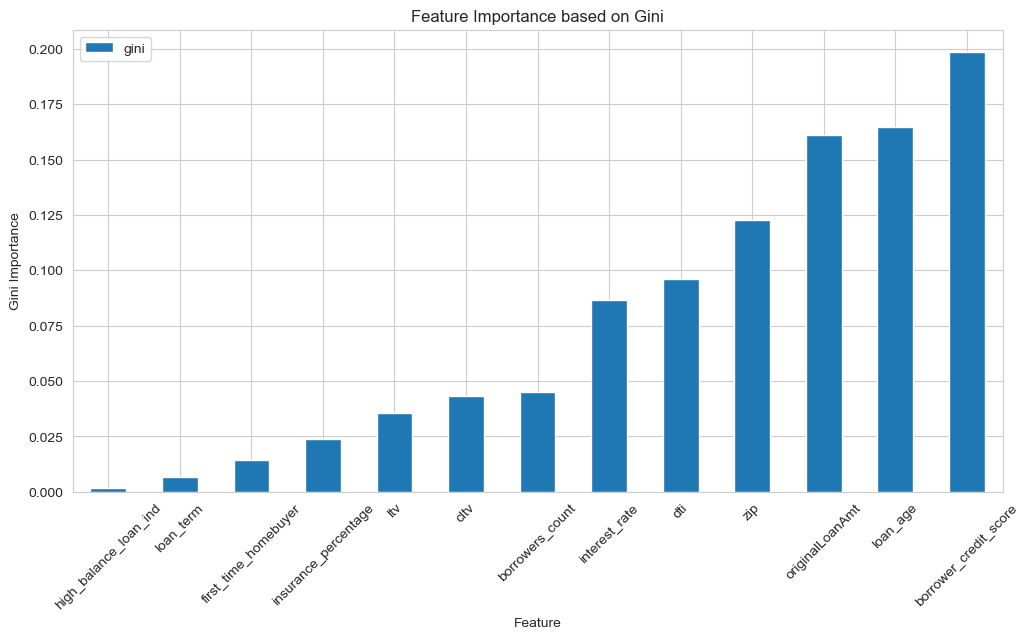

In [33]:
bestParameters = pd.DataFrame.from_dict([bestParams])
bestCriterion = bestParameters['criterion'] 
print(bestCriterion[0])
importances = pd.DataFrame.from_dict(bestFeatures, orient='index' ).rename(columns={0: bestCriterion[0]})
importances.sort_values(by = bestCriterion[0]).plot(kind='bar', rot=45,figsize=(12, 6),align = 'center')
plt.xlabel('Feature')
plt.ylabel('Gini Importance')
plt.title('Feature Importance based on Gini')
plt.show()

In [17]:
print(bestParameters['max_depth'][0])

None


****filtered_data*****
foreclosured loans in filtered_data : 3057
Good loans in filtered_data : 1223241
selected columns for forclosure prediction
['originalLoanAmt', 'interest_rate', 'borrowers_count', 'dti', 'loan_term', 'cltv', 'ltv', 'loan_age', 'borrower_credit_score', 'high_balance_loan_ind', 'first_time_homebuyer', 'insurance_percentage', 'zip']
***************************************************************************************************
RandomForest Classifier : Confusion matrix -- training data
[[856268      0]
 [   149   1991]]
***RandomForest Classifer, with randomized Search Classification report training data ****
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    856268
           1       1.00      0.93      0.96      2140

    accuracy                           1.00    858408
   macro avg       1.00      0.97      0.98    858408
weighted avg       1.00      1.00      1.00    858408

RandomForest Classifier tree: Ac

C:\Users\Pallavi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Pallavi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Pallavi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    366973
           1       0.00      0.00      0.00       917

    accuracy                           1.00    367890
   macro avg       0.50      0.50      0.50    367890
weighted avg       1.00      1.00      1.00    367890



RandomForest Classifer tree: Accuracy score - Test Data : 0.9975074071053848
***********************************************************************************************


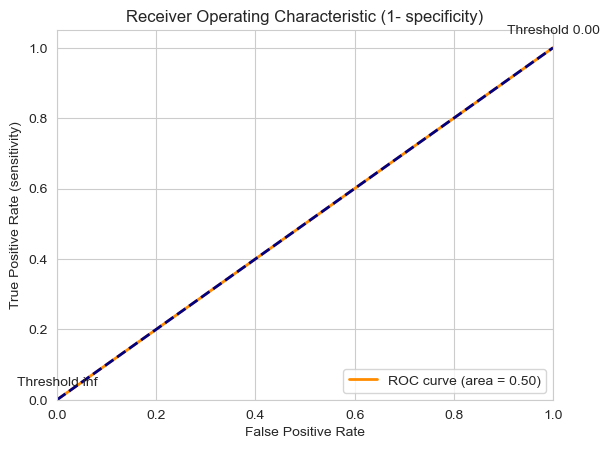

In [34]:
make_random_forest_predictions(data,bestParameters,importances.index.tolist())

    

****filtered_data*****
foreclosured loans in filtered_data : 3057
Good loans in filtered_data : 1223241
selected columns for forclosure prediction
['dti', 'borrower_credit_score', 'originalLoanAmt']
***************************************************************************************************
RandomForest Classifier : Confusion matrix -- training data
[[855127   1141]
 [   182   1958]]
***RandomForest Classifer, with randomized Search Classification report training data ****
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    856268
           1       0.63      0.91      0.75      2140

    accuracy                           1.00    858408
   macro avg       0.82      0.96      0.87    858408
weighted avg       1.00      1.00      1.00    858408

RandomForest Classifier tree: Accuracy score  training data : " 0.9984587748483239
***************************************************************************************************



--

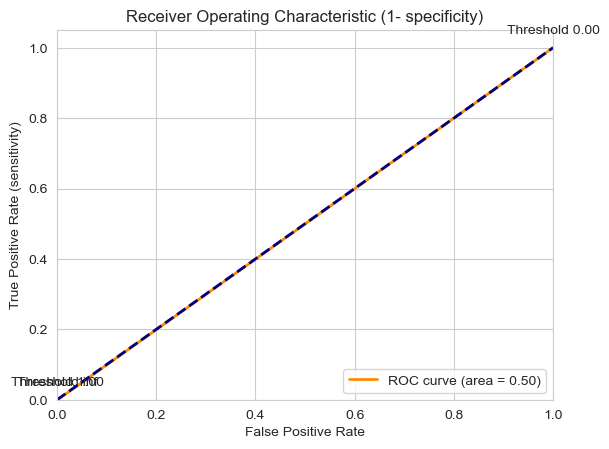

In [35]:
columns = ['dti', 'borrower_credit_score','originalLoanAmt']
make_random_forest_predictions(data,bestParameters,columns)

In [54]:
columns = ['dti', 'borrower_credit_score','interest_rate']
make_random_forest_predictions(data,bestParameters,columns)

calling the function *****
****filtered_data*****
['dti', 'borrower_credit_score', 'interest_rate']
(1300002, 2)
Decision tree: Confusion matrix
[[1251705   46737]
 [   1492      68]]
*************RandomForest Classifer, with randomized Search Classification report ***************************
              precision    recall  f1-score   support

           0       1.00      0.96      0.98   1298442
           1       0.00      0.04      0.00      1560

    accuracy                           0.96   1300002
   macro avg       0.50      0.50      0.49   1300002
weighted avg       1.00      0.96      0.98   1300002

*************************************************************************************************************
RandomForest Classifer tree: Accuracy score " 0.962900826306421


In [69]:
columns = ['dti']
make_random_forest_predictions(data,bestParameters,columns)

****filtered_data*****
['dti']
**************************************************************************************************************
RandomForest Classifier : Confusion matrix -- training data
[[1761489 1268209]
 [   1544    2096]]
*********RandomForest Classifer, with randomized Search Classification report training data ******************
RandomForest Classifier tree: Accuracy score  training data : " 0.5814007538889501
**************************************************************************************************************
****************************************************************************************************************
RanForest Classifer - Test Data: Confusion matrix
[[754810 543632]
 [   656    904]]
*********** RandomForest Classifer, with randomized Search Classification report ***Test Data ******************
              precision    recall  f1-score   support

           0       1.00      0.58      0.73   1298442
           1       0.00      0.58 

****filtered_data*****
foreclosured loans in filtered_data : 3057
Good loans in filtered_data : 1223241
selected columns for forclosure prediction
['borrower_credit_score']
***************************************************************************************************
RandomForest Classifier : Confusion matrix -- training data
[[573819 282449]
 [   748   1392]]
***RandomForest Classifer, with randomized Search Classification report training data ****
              precision    recall  f1-score   support

           0       1.00      0.67      0.80    856268
           1       0.00      0.65      0.01      2140

    accuracy                           0.67    858408
   macro avg       0.50      0.66      0.41    858408
weighted avg       1.00      0.67      0.80    858408

RandomForest Classifier tree: Accuracy score  training data : " 0.6700904465009646
***************************************************************************************************



----------------------------

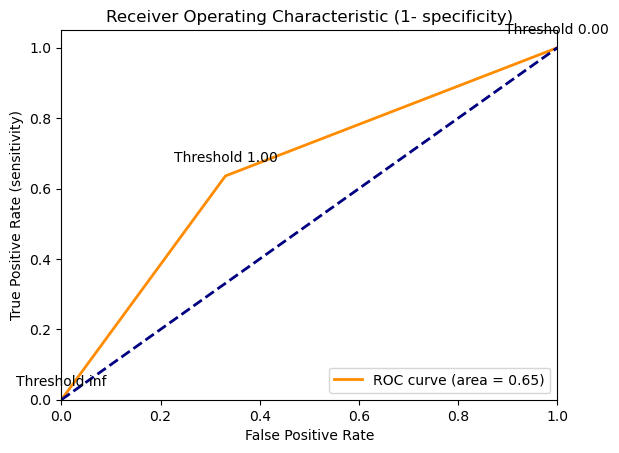

In [118]:
columns = ['borrower_credit_score']
make_random_forest_predictions(data,bestParameters,columns)

*****Calling Random Forest algorithm with Minority OverSampling Technique******

****filtered_data*****
selected columns for forclosure prediction
['borrower_credit_score']
Training Data: foreclosured and good loans count before SMOTE :
 0    856268
1      2140
Name: foreclosured, dtype: int64
Test Data: foreclosured and good loans count before SMOTE :
 0    366973
1       917
Name: foreclosured, dtype: int64
Training Data: foreclosured and good loans count After SMOTE :
 0    366973
1    366973
Name: foreclosured, dtype: int64
Test Data: foreclosured and good loans count After SMOTE :
 0    366973
1    366973
Name: foreclosured, dtype: int64
***************************************************************************************************
RandomForest Classifier : Confusion matrix -- training data
[[589255 267013]
 [293998 562270]]
***RandomForest Classifer, with randomized Search Classification report training data ****
              precision    recall  f1-score   support

           0       0.67      0.69      0.68    856268
           1       0.68      0.66  

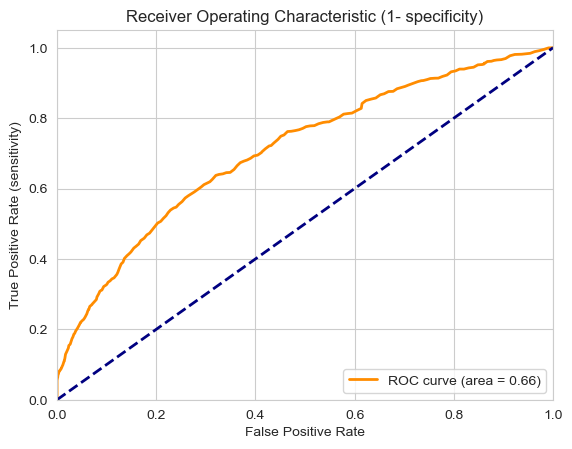

In [39]:
columns = ['borrower_credit_score']
random_forest_random_sampling (data,bestParameters,columns)
    
  

****filtered_data*****
selected columns for forclosure prediction
['dti', 'borrower_credit_score', 'interest_rate']
Training Data: foreclosured and good loans count before SMOTE :
 0    856268
1      2140
Name: foreclosured, dtype: int64
Test Data: foreclosured and good loans count before SMOTE :
 0    366973
1       917
Name: foreclosured, dtype: int64
Training Data: foreclosured and good loans count After SMOTE :
 0    366973
1    366973
Name: foreclosured, dtype: int64
Test Data: foreclosured and good loans count After SMOTE :
 0    366973
1    366973
Name: foreclosured, dtype: int64
***************************************************************************************************
RandomForest Classifier : Confusion matrix -- training data
[[854764   1504]
 [  2039 854229]]
***RandomForest Classifer, with randomized Search Classification report training data ****
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    856268
           

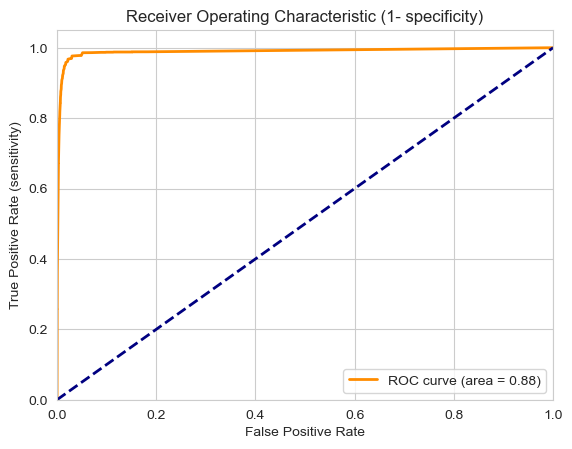

In [46]:
columns = ['dti', 'borrower_credit_score','interest_rate']
random_forest_random_sampling(data,bestParameters,columns)

In [49]:

make_logistic_predictions_smote(data,optimalC)

****filtered_data*****
After Sampling foreclosured loans in filtered_data : 3057
After Sampling  Good loans in filtered_data : 6114
LogicsticRegression: Cross-Validation Scores: [0.69813084 0.70841121 0.68536699]
Mean CV Score: 0.69730301666572
LogicsticRegression: Standard Deviation of CV Scores: 0.009425957094716947
LogicsticRegression : Test Set Model score: 0.7027574388534039
Confusion matrix
[[1216  571]
 [ 292  673]]
************* LogicsticRegression Classification report ***************************
              precision    recall  f1-score   support

           0       0.81      0.68      0.74      1787
           1       0.54      0.70      0.61       965

    accuracy                           0.69      2752
   macro avg       0.67      0.69      0.67      2752
weighted avg       0.71      0.69      0.69      2752

***********************************************************************************
LogicsticRegression Accuracy score " 0.6864098837209303
LogicsticRegression ro

In [42]:
correlations = data.corr()
target_correlations = abs(correlations['foreclosured'])
top_features = target_correlations.sort_values(ascending=False)#.index[:N]
print(top_features)

C:\Users\Pallavi\AppData\Local\Temp\ipykernel_9600\1401824051.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = data.corr()


foreclosured              1.000000
current_interest_rate     0.032833
borrower_credit_score     0.032166
interest_rate             0.023365
cltv                      0.022636
ltv                       0.022287
borrowers_count           0.019890
balance                   0.019327
originalLoanAmt           0.017435
first_time_homebuyer      0.016467
loan_age                  0.011460
loan_term                 0.011034
dti                       0.010761
insurance_percentage      0.008543
zip                       0.005387
loan_purpose              0.005255
high_balance_loan_ind     0.004006
seller                    0.002690
units_num                 0.002234
property_type             0.002111
relocation_indicator      0.002036
property_state            0.002018
property_state_n          0.001896
origination_date_month    0.001197
origination_date          0.001197
acquisition_date          0.000902
origination_date_year     0.000777
channel                   0.000658
loanId              

In [144]:
from sklearn.linear_model import LogisticRegression

fdata = data.drop(columns=['origination_date','acquisition_date','reporting_period','current_interest_rate','insurance_percentage'])
fdata=  fdata.dropna(axis= 0, how='any')
X = fdata.drop(columns =['foreclosured'])
y= fdata['foreclosured']
X_train, Xtest, y_train, ytest = train_test_split(X, y, test_size=0.3, stratify=y)
model = LogisticRegression(solver='liblinear',penalty='l2', C=1.0)  # Adjust C for regularization strength
model.fit(X_train, y_train)

top_features = np.where(model.coef_[0] != 0)[0]
print(top_features)
print(X.columns)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Index(['loanId', 'channel', 'seller', 'interest_rate', 'originalLoanAmt',
       'loan_term', 'balance', 'loan_age', 'ltv', 'cltv', 'borrowers_count',
       'dti', 'borrower_credit_score', 'first_time_homebuyer', 'loan_purpose',
       'property_type', 'units_num', 'property_state', 'zip',
       'relocation_indicator', 'high_balance_loan_ind',
       'origination_date_month', 'origination_date_year', 'property_state_n'],
      dtype='object')


****filtered_data*****
foreclosured loans in filtered_data : 3057
Good loans in filtered_data : 1223241
After Sampling foreclosured loans in filtered_data : 3057
After Sampling  Good loans in filtered_data : 6114
selected columns for forclosure prediction
['dti', 'borrower_credit_score', 'originalLoanAmt', 'first_time_homebuyer', 'high_balance_loan_ind', 'ltv', 'cltv', 'loan_term', 'borrowers_count', 'insurance_percentage', 'loan_age', 'zip']
***************************************************************************************************
RandomForest Classifier : Confusion matrix -- training data
[[4115  164]
 [  85 2055]]
***RandomForest Classifer, with randomized Search Classification report training data ****
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      4279
           1       0.93      0.96      0.94      2140

    accuracy                           0.96      6419
   macro avg       0.95      0.96      0.96      6419
wei

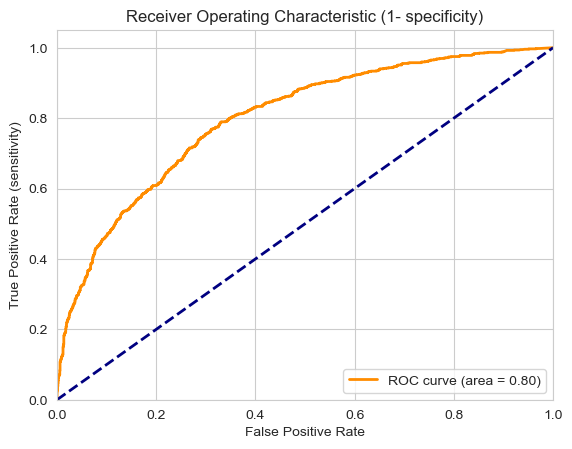

In [51]:
columns = ['dti', 'borrower_credit_score','originalLoanAmt','first_time_homebuyer','high_balance_loan_ind','ltv','cltv','loan_term','borrowers_count','insurance_percentage','loan_age','zip']
rf_predictions = make_random_forest_with_balancing(data,bestParameters,columns)


In [78]:
false_neg['origination_date_year'].unique()

array([2017, 2016, 2015], dtype=int64)

In [85]:
print(false_neg[(false_neg['origination_date_year'] == 2017) & (false_neg['foreclosured']==0) & (false_neg['prediction'] ==1)])

          dti  borrower_credit_score  originalLoanAmt  first_time_homebuyer  \
3865624  34.0                  659.0         238000.0                     0   
2628309  50.0                  788.0         170000.0                     0   
411515   29.0                  690.0         285000.0                     1   
232597   18.0                  657.0         109000.0                     1   
1319355  39.0                  629.0          87000.0                     1   
...       ...                    ...              ...                   ...   
619708   38.0                  701.0         162000.0                     1   
1222095  46.0                  700.0         212000.0                     0   
2294069  36.0                  732.0         154000.0                     0   
943934   14.0                  716.0          57000.0                     1   
438132   42.0                  698.0         428000.0                     0   

         high_balance_loan_ind  ltv  cltv  loan_ter

In [91]:
print(false_neg.head(5))

          dti  borrower_credit_score  originalLoanAmt  first_time_homebuyer  \
3865624  34.0                  659.0         238000.0                     0   
2628309  50.0                  788.0         170000.0                     0   
411515   29.0                  690.0         285000.0                     1   
232597   18.0                  657.0         109000.0                     1   
1319355  39.0                  629.0          87000.0                     1   

         high_balance_loan_ind  ltv  cltv  loan_term  borrowers_count  \
3865624                      0   88    88        360                1   
2628309                      0   97    97        360                1   
411515                       0   95    95        360                1   
232597                       0   95    95        360                1   
1319355                      0   90    90        360                1   

         insurance_percentage  loan_age    zip  origination_date_year  \
3865624      

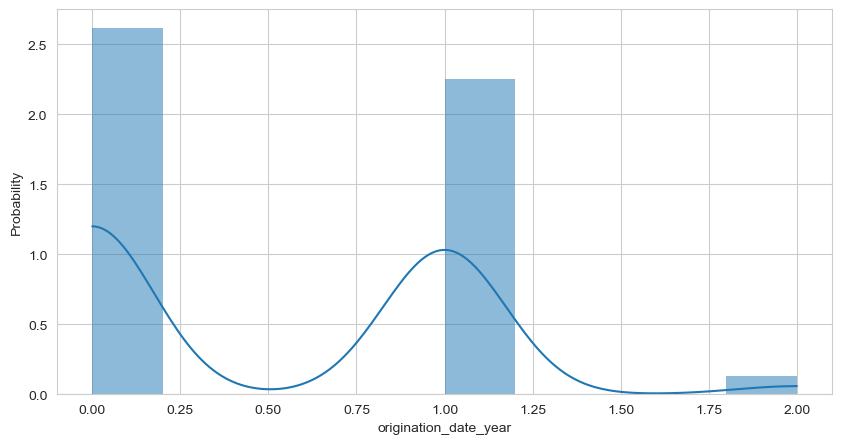

In [54]:
false_neg =  rf_predictions[(rf_predictions['foreclosured']==0) & (rf_predictions['prediction']==1)]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
#sns.distplot(2017-false_neg['origination_date_year'],kde = True)

sns.histplot(2017 - false_neg['origination_date_year'], kde=True, ax=ax,stat="density", linewidth=0)

ax.set_ylabel('Probability');

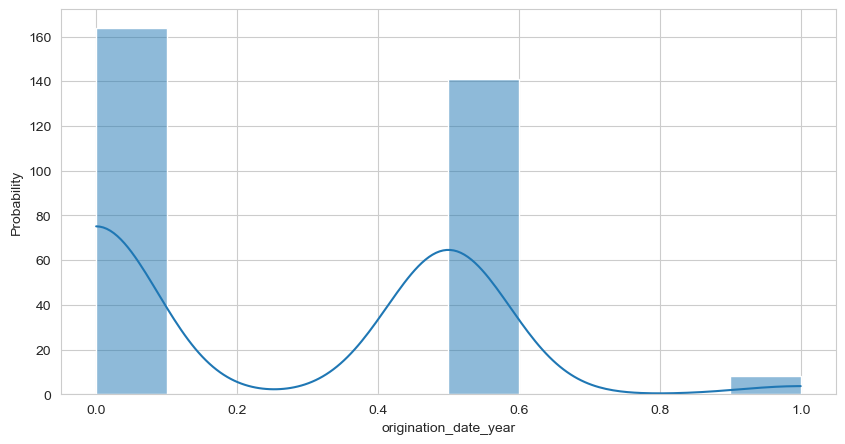

In [55]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
normalized_data = (2017. - false_neg['origination_date_year']) / (2017. - false_neg['origination_date_year']).max()

# Use sns.histplot with the normalized data to create a histogram
sns.histplot(normalized_data, kde=True, ax=ax)

# Set the ylabel
ax.set_ylabel('Probability')

# Show the plot
plt.show()

In [58]:
false_neg1 = false_neg[['origination_date_year','foreclosured','prediction']]
grouped_result = false_neg1.groupby(['origination_date_year']).count()
grouped_result = grouped_result.rename(columns={'foreclosured': 'foreclosured = 0 '})
print(grouped_result)


                       foreclosured = 0   prediction
origination_date_year                               
2015                                   8           8
2016                                 141         141
2017                                 164         164


In [67]:
defaults = data[data['foreclosured']==1.0]
good = data[data['foreclosured']==0.0]
frac = (1.0*defaults.shape[0])/(1.0*good.shape[0])
filtered_data = pd.concat([defaults, good.sample(frac=frac*2.)]).sample(frac=1.0)

print(frac)
print(frac*2.)
print(1.0*defaults.shape[0])
print(1.0*good.shape[0])

0.0012027587022212822
0.0024055174044425643
5209.0
4330877.0
